In [1]:
import csv
import re
import typing as t
from collections import defaultdict
from pathlib import Path

import nltk
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from nltk.corpus import stopwords, wordnet
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from tqdm import tqdm

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
DATA_DIR = Path("data/")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE.upper()} device")

Using CUDA device


In [4]:
def on_cuda(device: str) -> bool:
    return device == "cuda"


def common_train(
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        train_dataloader: DataLoader,
        epochs: int,
        test_dataloader: DataLoader = None,
        lr_scheduler=None,
        verbose: int = 100,
        device: str = "cpu",
) -> t.List[float]:
    train_losses = []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}\n" + "-" * 32)
        train_loss = train_loop(
            train_dataloader,
            model,
            loss_fn,
            optimizer,
            verbose=verbose,
            device=device,
        )
        train_losses.append(train_loss.item())
        if test_dataloader:
            loss, acc = test_loop(test_dataloader, model, loss_fn, device=device)
            if lr_scheduler:
                lr_scheduler.step(loss)
        torch.cuda.empty_cache()
    return train_losses


def train_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        verbose: int = 100,
        device: str = "cpu",
) -> torch.Tensor:
    model.train()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss = 0

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        avg_loss += loss
        if batch % verbose == 0:
            print(f"loss: {loss:>7f}  [{batch * len(x):>5d}/{size:>5d}]")

        del x, y, pred, loss
        torch.cuda.empty_cache()

    return avg_loss / num_batches


@torch.no_grad()
def test_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        device: str = "cpu",
) -> t.Tuple[torch.Tensor, torch.Tensor]:
    model.eval()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss, correct = 0, 0

    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        avg_loss += loss_fn(pred, y)
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()  # noqa

        del x, y, pred
        torch.cuda.empty_cache()

    avg_loss /= num_batches
    accuracy = correct / size
    print(f"Test Error: \n Accuracy: {accuracy:>4f}, Avg loss: {avg_loss:>8f} \n")

    return avg_loss, accuracy


def train_test_split(dataset: t.Union[Dataset, t.Sized], train_part: float) -> t.Tuple[Subset, Subset]:
    train_size = round(train_part * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, lengths=(train_size, test_size))
    return train_dataset, test_dataset


@torch.no_grad()
def get_y_test_y_pred(
        model: nn.Module,
        test_dataloader: DataLoader,
        device: str = "cpu",
) -> t.Tuple[torch.Tensor, torch.Tensor]:
    model.eval()

    y_test = []
    y_pred = []
    for x, y in test_dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x).argmax(1)
        y_test.append(y)
        y_pred.append(pred)

        del x
        torch.cuda.empty_cache()

    return torch.hstack(y_test).detach().cpu(), torch.hstack(y_pred).detach().cpu()

## 1. Классификация фамилий (RNN)

Датасет: https://disk.yandex.ru/d/frNchuaBQVLxyA?w=1

1.1 Используя класс `nn.RNNCell` (абстракцию для отдельного временного шага RNN), реализуйте простейшую рекуррентную сеть Элмана в виде класса `RNN`. Используя созданный класс `RNN`, решите задачу классификации фамилий. 


In [5]:
class RNN(nn.Module):

    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.rnn_cell = nn.RNNCell(input_size, hidden_size)

    def forward(self, inputs: torch.Tensor, hx: torch.Tensor = None):
        batch_size, sequence_size, _ = inputs.size()
        inputs = inputs.permute(1, 0, 2)  # для nn.RNNCell batch_size должен быть на 2-ом месте

        if hx is None:
            # инициализация как в nn.RNN
            hx = torch.zeros(batch_size, self.hidden_size, dtype=inputs.dtype, device=inputs.device)
        else:
            # 1-ая размерность равная 1 для совместимости с nn.RNN
            hx = hx.squeeze(0)  # избавляемся от 1-ой размерности равной 1

        hidden = []
        for i in range(sequence_size):
            hx = self.rnn_cell(inputs[i], hx)
            hidden.append(hx)

        hidden = torch.stack(hidden)
        hx = hidden[-1].unsqueeze(0)
        # выход и скрытое состояние размерностей: (batch_size, ...), (1, batch_size, ...)
        return hidden.permute(1, 0, 2), hx

Проверка реализации RNN:

In [6]:
torch.manual_seed(0)

input_size, hidden_size = 4, 5
inputs = torch.randn(2, 3, input_size)
hx = torch.randn(1, 2, hidden_size)

torch.manual_seed(0)
my_rnn = RNN(input_size=input_size, hidden_size=hidden_size)

torch.manual_seed(0)
true_rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)

In [7]:
my_rnn(inputs, hx)

(tensor([[[ 0.6515,  0.5430,  0.4023,  0.6325, -0.6068],
          [ 0.9149, -0.1088,  0.6385, -0.7387,  0.7532],
          [-0.6936,  0.5123, -0.2784, -0.5693, -0.0055]],
 
         [[ 0.1954,  0.6152,  0.2958, -0.8005,  0.8074],
          [-0.4577,  0.7566,  0.2972, -0.8834,  0.1265],
          [ 0.7166,  0.1516,  0.8047, -0.2007,  0.8192]]],
        grad_fn=<PermuteBackward>),
 tensor([[[-0.6936,  0.5123, -0.2784, -0.5693, -0.0055],
          [ 0.7166,  0.1516,  0.8047, -0.2007,  0.8192]]],
        grad_fn=<UnsqueezeBackward0>))

In [8]:
true_rnn(inputs, hx)

(tensor([[[ 0.6515,  0.5430,  0.4023,  0.6325, -0.6068],
          [ 0.9149, -0.1088,  0.6385, -0.7387,  0.7532],
          [-0.6936,  0.5123, -0.2784, -0.5693, -0.0055]],
 
         [[ 0.1954,  0.6152,  0.2958, -0.8005,  0.8074],
          [-0.4577,  0.7566,  0.2972, -0.8834,  0.1265],
          [ 0.7166,  0.1516,  0.8047, -0.2007,  0.8192]]],
        grad_fn=<TransposeBackward1>),
 tensor([[[-0.6936,  0.5123, -0.2784, -0.5693, -0.0055],
          [ 0.7166,  0.1516,  0.8047, -0.2007,  0.8192]]],
        grad_fn=<StackBackward>))

✅ 100% совпадение

In [9]:
class SurnamesRNNClassifier(nn.Module):

    def __init__(
            self,
            num_embeddings: int,
            embedding_dim: int,
            rnn_hidden_size: int,
            vector_size: int,
            num_classes: int,
    ):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim, padding_idx=0)
        self.rnn = RNN(input_size=embedding_dim, hidden_size=rnn_hidden_size)
        self.classifier = nn.Sequential(
            nn.Linear(rnn_hidden_size * vector_size, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embedding(x)
        # здесь позволим себе потерять скрытое состояние hx
        # в будущих моделях будем его сохранять
        x, hx = self.rnn(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

In [10]:
class SurnamesVocab:
    pad = "<PAD>"

    def __init__(self, surnames: t.List[str]):
        uniques = set()
        max_len = 0
        for w in map(str.lower, surnames):
            uniques.update(w)
            max_len = max(len(w), max_len)

        self.alphabet = [self.pad, *uniques]
        self.max_len = max_len
        self.ch2i = {ch: i for i, ch in enumerate(self.alphabet)}

    def __len__(self):
        return len(self.alphabet)

    def encode(self, word: str) -> torch.Tensor:
        indices = [self.ch2i[ch] for ch in word]
        indices += [self.ch2i[self.pad]] * (self.max_len - len(indices))
        return torch.tensor(indices, dtype=torch.long)

    def decode(self, indices: torch.Tensor) -> str:
        pad_indices = torch.nonzero(indices == self.ch2i[self.pad], as_tuple=True)[0]
        if len(pad_indices):
            indices = indices[:pad_indices[0]]
        return "".join(self.alphabet[i] for i in indices)


class SurnamesDataset(Dataset):
    df: pd.DataFrame
    surnames: t.List[str]
    vocab: SurnamesVocab
    labeler: LabelEncoder
    data: torch.Tensor
    targets: torch.Tensor

    def __init__(self, path: Path):
        self.df = pd.read_csv(path)

        self.surnames = self.df["surname"].tolist()
        self.vocab = SurnamesVocab(self.surnames)
        size = self.vocab.encode(self.surnames[0].lower()).size()
        data = torch.vstack([self.vocab.encode(w.lower()) for w in self.surnames])
        self.data = data.view(len(self.surnames), *size)

        self.labeler = LabelEncoder()
        targets = self.labeler.fit_transform(self.df["nationality"])
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

    def encode(self, word: str) -> torch.Tensor:
        return self.vocab.encode(word)

    def decode(self, indices: torch.Tensor) -> str:
        return self.vocab.decode(indices)

In [11]:
surnames_dataset = SurnamesDataset(DATA_DIR / "surnames.csv")
len(surnames_dataset)

10980

In [12]:
torch.manual_seed(0)

train_surnames_dataset, test_surnames_dataset = train_test_split(surnames_dataset, train_part=0.8)
print(len(train_surnames_dataset), len(test_surnames_dataset))

8784 2196


### Handmade RNN

In [13]:
torch.manual_seed(0)

handmade_rnn_net = SurnamesRNNClassifier(
    num_embeddings=len(surnames_dataset.vocab),
    embedding_dim=128,
    rnn_hidden_size=64,
    vector_size=surnames_dataset.vocab.max_len,
    num_classes=len(surnames_dataset.labeler.classes_),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(handmade_rnn_net.parameters(), lr=0.0015)

train_dataloader = DataLoader(train_surnames_dataset, batch_size=128, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_surnames_dataset, batch_size=512)

In [14]:
%%time

_ = common_train(
    epochs=20,
    model=handmade_rnn_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    verbose=50,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 2.891901  [    0/ 8784]
loss: 1.465396  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.622495, Avg loss: 1.298633 

Epoch 2
--------------------------------
loss: 1.154157  [    0/ 8784]
loss: 1.179678  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.694444, Avg loss: 1.057449 

Epoch 3
--------------------------------
loss: 1.036496  [    0/ 8784]
loss: 0.837359  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.718579, Avg loss: 0.964127 

Epoch 4
--------------------------------
loss: 0.856482  [    0/ 8784]
loss: 0.841396  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.734062, Avg loss: 0.924591 

Epoch 5
--------------------------------
loss: 0.664573  [    0/ 8784]
loss: 0.949235  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.744080, Avg loss: 0.865812 

Epoch 6
--------------------------------
loss: 0.722839  [    0/ 8784]
loss: 0.614783  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.747268, Avg loss: 0.872199 

Epoch 7
--------------------------------
loss: 0.515337  [    0/

In [15]:
y_test, y_pred = get_y_test_y_pred(handmade_rnn_net, test_dataloader, DEVICE)

print(metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred,
    target_names=surnames_dataset.labeler.classes_,
    zero_division=True,
))

              precision    recall  f1-score   support

      Arabic       0.97      1.00      0.98       340
     Chinese       0.78      0.76      0.77        38
       Czech       0.58      0.33      0.42        96
       Dutch       0.59      0.43      0.50        51
     English       0.72      0.86      0.79       573
      French       0.18      0.05      0.08        39
      German       0.56      0.49      0.52       121
       Greek       0.70      0.62      0.66        34
       Irish       0.60      0.32      0.42        37
     Italian       0.71      0.76      0.73       128
    Japanese       0.86      0.88      0.87       156
      Korean       0.36      0.40      0.38        10
      Polish       0.57      0.50      0.53        26
  Portuguese       0.00      0.00      0.00         9
     Russian       0.83      0.88      0.85       458
    Scottish       0.00      0.00      0.00        17
     Spanish       0.46      0.36      0.40        50
  Vietnamese       0.25    

1.2 Замените модуль `RNN` из 1.1 на модули `nn.RNN`, `nn.LSTM` и `nn.GRU` (не забудьте указать аргумент `batch_first=True`). Сравните результаты работы.

In [16]:
class SurnamesAutobotRNNClassifier(nn.Module):

    def __init__(
            self,
            rnn_cls: t.Union[t.Type[nn.RNN], t.Type[nn.LSTM], t.Type[nn.GRU]],
            num_embeddings: int,
            embedding_dim: int,
            rnn_hidden_size: int,
            vector_size: int,
            num_classes: int,
    ):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim, padding_idx=0)
        self.hx, self.cx = None, None
        self.rnn = rnn_cls(input_size=embedding_dim, hidden_size=rnn_hidden_size)
        self.classifier = nn.Sequential(
            nn.Linear(rnn_hidden_size * vector_size, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embedding(x)

        if isinstance(self.rnn, (nn.RNN, nn.GRU)):
            x, hx = self.rnn(x, self.hx)
            self.hx = hx.detach()
        else:
            if self.hx is not None and self.cx is not None:
                hx_cx = (self.hx, self.cx)
            else:
                hx_cx = None
            x, (hx, cx) = self.rnn(x, hx_cx)
            self.cx = cx.detach()
            self.hx = hx.detach()

        x = torch.flatten(x, 1)
        return self.classifier(x)

### nn.RNN

In [17]:
torch.manual_seed(0)

rnn_net = SurnamesAutobotRNNClassifier(
    rnn_cls=nn.RNN,
    num_embeddings=len(surnames_dataset.vocab),
    embedding_dim=128,
    rnn_hidden_size=64,
    vector_size=surnames_dataset.vocab.max_len,
    num_classes=len(surnames_dataset.labeler.classes_),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_net.parameters(), lr=0.0015)

train_dataloader = DataLoader(train_surnames_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_surnames_dataset, batch_size=512)

In [18]:
%%time

_ = common_train(
    epochs=20,
    model=rnn_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    verbose=50,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 2.894483  [    0/ 8784]
loss: 1.630486  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.581512, Avg loss: 1.438731 

Epoch 2
--------------------------------
loss: 1.345863  [    0/ 8784]
loss: 1.308324  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.644809, Avg loss: 1.212533 

Epoch 3
--------------------------------
loss: 1.161597  [    0/ 8784]
loss: 1.007689  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.674408, Avg loss: 1.111740 

Epoch 4
--------------------------------
loss: 1.016940  [    0/ 8784]
loss: 0.884982  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.694900, Avg loss: 1.034357 

Epoch 5
--------------------------------
loss: 0.955447  [    0/ 8784]
loss: 1.070568  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.710838, Avg loss: 1.011102 

Epoch 6
--------------------------------
loss: 0.977373  [    0/ 8784]
loss: 0.827253  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.720856, Avg loss: 0.972597 

Epoch 7
--------------------------------
loss: 0.657779  [    0/

In [19]:
y_test, y_pred = get_y_test_y_pred(rnn_net, test_dataloader, DEVICE)

print(metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred,
    target_names=surnames_dataset.labeler.classes_,
    zero_division=True,
))

              precision    recall  f1-score   support

      Arabic       0.97      1.00      0.99       340
     Chinese       0.76      0.76      0.76        38
       Czech       0.44      0.23      0.30        96
       Dutch       0.80      0.39      0.53        51
     English       0.68      0.87      0.77       573
      French       0.20      0.08      0.11        39
      German       0.59      0.48      0.53       121
       Greek       0.56      0.44      0.49        34
       Irish       0.62      0.22      0.32        37
     Italian       0.66      0.64      0.65       128
    Japanese       0.83      0.86      0.84       156
      Korean       0.27      0.30      0.29        10
      Polish       0.50      0.38      0.43        26
  Portuguese       0.00      0.00      0.00         9
     Russian       0.83      0.87      0.85       458
    Scottish       0.00      0.00      0.00        17
     Spanish       0.38      0.32      0.35        50
  Vietnamese       0.50    

### nn.LSTM

In [20]:
torch.manual_seed(0)

lstm_net = SurnamesAutobotRNNClassifier(
    rnn_cls=nn.LSTM,
    num_embeddings=len(surnames_dataset.vocab),
    embedding_dim=128,
    rnn_hidden_size=64,
    vector_size=surnames_dataset.vocab.max_len,
    num_classes=len(surnames_dataset.labeler.classes_),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_net.parameters(), lr=0.0015)

train_dataloader = DataLoader(train_surnames_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_surnames_dataset, batch_size=512)

In [21]:
%%time

_ = common_train(
    epochs=20,
    model=lstm_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    verbose=50,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 2.884699  [    0/ 8784]
loss: 1.878506  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.540073, Avg loss: 1.575988 

Epoch 2
--------------------------------
loss: 1.447626  [    0/ 8784]
loss: 1.610469  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.618852, Avg loss: 1.319369 

Epoch 3
--------------------------------
loss: 1.309874  [    0/ 8784]
loss: 1.262846  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.662568, Avg loss: 1.176828 

Epoch 4
--------------------------------
loss: 1.032387  [    0/ 8784]
loss: 1.082438  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.682149, Avg loss: 1.096950 

Epoch 5
--------------------------------
loss: 1.021482  [    0/ 8784]
loss: 0.957862  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.699454, Avg loss: 1.029817 

Epoch 6
--------------------------------
loss: 1.058702  [    0/ 8784]
loss: 0.979626  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.714481, Avg loss: 0.979212 

Epoch 7
--------------------------------
loss: 0.868596  [    0/

In [22]:
y_test, y_pred = get_y_test_y_pred(lstm_net, test_dataloader, DEVICE)

print(metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred,
    target_names=surnames_dataset.labeler.classes_,
    zero_division=True,
))

              precision    recall  f1-score   support

      Arabic       0.96      1.00      0.98       340
     Chinese       0.71      0.76      0.73        38
       Czech       0.50      0.20      0.28        96
       Dutch       0.73      0.47      0.57        51
     English       0.68      0.87      0.76       573
      French       0.00      0.00      0.00        39
      German       0.56      0.40      0.46       121
       Greek       0.68      0.56      0.61        34
       Irish       0.65      0.30      0.41        37
     Italian       0.62      0.73      0.67       128
    Japanese       0.84      0.83      0.84       156
      Korean       0.30      0.30      0.30        10
      Polish       0.47      0.31      0.37        26
  Portuguese       0.25      0.11      0.15         9
     Russian       0.81      0.87      0.84       458
    Scottish       0.00      0.00      0.00        17
     Spanish       0.56      0.40      0.47        50
  Vietnamese       1.00    

### nn.GRU

In [23]:
torch.manual_seed(0)

gru_net = SurnamesAutobotRNNClassifier(
    rnn_cls=nn.GRU,
    num_embeddings=len(surnames_dataset.vocab),
    embedding_dim=128,
    rnn_hidden_size=64,
    vector_size=surnames_dataset.vocab.max_len,
    num_classes=len(surnames_dataset.labeler.classes_),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(gru_net.parameters(), lr=0.0015)

train_dataloader = DataLoader(train_surnames_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_surnames_dataset, batch_size=512)

In [24]:
%%time

_ = common_train(
    epochs=20,
    model=gru_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    verbose=50,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 2.875168  [    0/ 8784]
loss: 1.732089  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.554645, Avg loss: 1.542402 

Epoch 2
--------------------------------
loss: 1.660108  [    0/ 8784]
loss: 1.294080  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.628871, Avg loss: 1.269239 

Epoch 3
--------------------------------
loss: 1.254287  [    0/ 8784]
loss: 1.296043  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.669854, Avg loss: 1.152408 

Epoch 4
--------------------------------
loss: 1.151398  [    0/ 8784]
loss: 1.006115  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.693534, Avg loss: 1.080060 

Epoch 5
--------------------------------
loss: 1.090511  [    0/ 8784]
loss: 0.937375  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.705829, Avg loss: 1.025246 

Epoch 6
--------------------------------
loss: 0.898771  [    0/ 8784]
loss: 0.731767  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.724044, Avg loss: 0.977456 

Epoch 7
--------------------------------
loss: 0.781482  [    0/

In [25]:
y_test, y_pred = get_y_test_y_pred(gru_net, test_dataloader, DEVICE)

print(metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred,
    target_names=surnames_dataset.labeler.classes_,
    zero_division=True,
))

              precision    recall  f1-score   support

      Arabic       0.95      1.00      0.97       340
     Chinese       0.81      0.76      0.78        38
       Czech       0.53      0.27      0.36        96
       Dutch       0.90      0.37      0.53        51
     English       0.69      0.87      0.77       573
      French       0.14      0.08      0.10        39
      German       0.60      0.40      0.48       121
       Greek       0.83      0.44      0.58        34
       Irish       0.74      0.38      0.50        37
     Italian       0.65      0.73      0.69       128
    Japanese       0.83      0.83      0.83       156
      Korean       0.33      0.40      0.36        10
      Polish       0.58      0.42      0.49        26
  Portuguese       0.00      0.00      0.00         9
     Russian       0.80      0.89      0.84       458
    Scottish       0.00      0.00      0.00        17
     Spanish       0.48      0.28      0.35        50
  Vietnamese       1.00    

1.3 Загрузите предобученные эмбеддинги (https://disk.yandex.ru/d/BHuT2tEXr_yBOQ?w=1) в модуль `nn.Embedding` и обучите модели из 1.2.

In [26]:
class SurnamesDecepticonRNNClassifier(nn.Module):

    def __init__(
            self,
            embedding: nn.Embedding,
            rnn_cls: t.Union[t.Type[nn.RNN], t.Type[nn.LSTM], t.Type[nn.GRU]],
            rnn_hidden_size: int,
            vector_size: int,
            num_classes: int,
    ):
        super().__init__()
        self.embedding = embedding
        self.hx, self.cx = None, None
        self.rnn = rnn_cls(input_size=self.embedding.embedding_dim, hidden_size=rnn_hidden_size)
        self.classifier = nn.Sequential(
            nn.Linear(rnn_hidden_size * vector_size, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, num_classes),
        )

    def reset_rnn_state(self):
        self.hx, self.cx = None, None

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embedding(x)

        if isinstance(self.rnn, (nn.RNN, nn.GRU)):
            x, hx = self.rnn(x, self.hx)
            self.hx = hx.detach()
        else:
            if self.hx is not None and self.cx is not None:
                hx_cx = (self.hx, self.cx)
            else:
                hx_cx = None
            x, (hx, cx) = self.rnn(x, hx_cx)
            self.hx = hx.detach()
            self.cx = cx.detach()

        x = torch.flatten(x, 1)
        return self.classifier(x)

In [27]:
torch.manual_seed(0)

embedding_weights = pd.read_csv(
    DATA_DIR / "glove.6B/glove.6B.50d.txt",
    sep=" ",
    quoting=csv.QUOTE_NONE,
    index_col=0,
    header=None,
)

weights = torch.ones(len(surnames_dataset.vocab), embedding_weights.shape[1], dtype=torch.float32)
torch.nn.init.normal_(weights)

miss = 0
for i, ch in enumerate(surnames_dataset.vocab.alphabet):
    try:
        weights[i] = torch.from_numpy(embedding_weights.loc[ch].to_numpy())
    except KeyError:
        miss += 1

embedding = nn.Embedding.from_pretrained(weights, padding_idx=0)
embedding, miss

(Embedding(56, 50, padding_idx=0), 5)

### nn.RNN

In [28]:
torch.manual_seed(0)

rnn_net = SurnamesDecepticonRNNClassifier(
    embedding=embedding,
    rnn_cls=nn.RNN,
    rnn_hidden_size=64,
    vector_size=surnames_dataset.vocab.max_len,
    num_classes=len(surnames_dataset.labeler.classes_),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_net.parameters(), lr=0.0015)

train_dataloader = DataLoader(train_surnames_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_surnames_dataset, batch_size=512)

In [29]:
%%time

_ = common_train(
    epochs=20,
    model=rnn_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    verbose=50,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 2.844056  [    0/ 8784]
loss: 1.964587  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.468579, Avg loss: 1.820964 

Epoch 2
--------------------------------
loss: 1.773107  [    0/ 8784]
loss: 1.707007  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.549180, Avg loss: 1.588969 

Epoch 3
--------------------------------
loss: 1.587244  [    0/ 8784]
loss: 1.545814  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.585155, Avg loss: 1.436049 

Epoch 4
--------------------------------
loss: 1.449910  [    0/ 8784]
loss: 1.292889  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.625228, Avg loss: 1.315430 

Epoch 5
--------------------------------
loss: 1.052271  [    0/ 8784]
loss: 1.246510  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.650273, Avg loss: 1.217674 

Epoch 6
--------------------------------
loss: 1.177599  [    0/ 8784]
loss: 1.405028  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.673042, Avg loss: 1.183046 

Epoch 7
--------------------------------
loss: 1.015822  [    0/

In [30]:
y_test, y_pred = get_y_test_y_pred(rnn_net, test_dataloader, DEVICE)

print(metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred,
    target_names=surnames_dataset.labeler.classes_,
    zero_division=True,
))

              precision    recall  f1-score   support

      Arabic       0.94      1.00      0.97       340
     Chinese       0.70      0.84      0.76        38
       Czech       0.42      0.22      0.29        96
       Dutch       0.76      0.25      0.38        51
     English       0.64      0.90      0.75       573
      French       0.50      0.08      0.13        39
      German       0.63      0.27      0.38       121
       Greek       0.62      0.47      0.53        34
       Irish       0.80      0.22      0.34        37
     Italian       0.59      0.70      0.64       128
    Japanese       0.81      0.85      0.83       156
      Korean       0.17      0.10      0.12        10
      Polish       0.47      0.27      0.34        26
  Portuguese       1.00      0.11      0.20         9
     Russian       0.83      0.84      0.84       458
    Scottish       0.00      0.00      0.00        17
     Spanish       0.44      0.16      0.24        50
  Vietnamese       0.33    

### nn.LSTM

In [31]:
torch.manual_seed(0)

lstm_net = SurnamesDecepticonRNNClassifier(
    embedding=embedding,
    rnn_cls=nn.LSTM,
    rnn_hidden_size=64,
    vector_size=surnames_dataset.vocab.max_len,
    num_classes=len(surnames_dataset.labeler.classes_),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_net.parameters(), lr=0.0015)

train_dataloader = DataLoader(train_surnames_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_surnames_dataset, batch_size=512)

In [32]:
%%time

_ = common_train(
    epochs=20,
    model=lstm_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    verbose=50,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 2.900342  [    0/ 8784]
loss: 2.213560  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.426685, Avg loss: 1.954773 

Epoch 2
--------------------------------
loss: 2.061828  [    0/ 8784]
loss: 1.852823  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.525046, Avg loss: 1.633880 

Epoch 3
--------------------------------
loss: 1.755817  [    0/ 8784]
loss: 1.605192  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.571038, Avg loss: 1.474017 

Epoch 4
--------------------------------
loss: 1.500857  [    0/ 8784]
loss: 1.445649  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.610656, Avg loss: 1.340348 

Epoch 5
--------------------------------
loss: 1.162403  [    0/ 8784]
loss: 1.348665  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.642077, Avg loss: 1.252978 

Epoch 6
--------------------------------
loss: 1.204712  [    0/ 8784]
loss: 1.063030  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.663479, Avg loss: 1.161660 

Epoch 7
--------------------------------
loss: 0.942881  [    0/

In [33]:
y_test, y_pred = get_y_test_y_pred(lstm_net, test_dataloader, DEVICE)

print(metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred,
    target_names=surnames_dataset.labeler.classes_,
    zero_division=True,
))

              precision    recall  f1-score   support

      Arabic       0.96      1.00      0.98       340
     Chinese       0.69      0.82      0.75        38
       Czech       0.53      0.22      0.31        96
       Dutch       0.64      0.27      0.38        51
     English       0.66      0.88      0.76       573
      French       0.11      0.05      0.07        39
      German       0.47      0.37      0.42       121
       Greek       0.61      0.50      0.55        34
       Irish       0.75      0.24      0.37        37
     Italian       0.67      0.75      0.71       128
    Japanese       0.83      0.83      0.83       156
      Korean       0.33      0.30      0.32        10
      Polish       0.57      0.31      0.40        26
  Portuguese       1.00      0.11      0.20         9
     Russian       0.83      0.83      0.83       458
    Scottish       0.00      0.00      0.00        17
     Spanish       0.67      0.36      0.47        50
  Vietnamese       0.50    

### nn.GRU

In [34]:
torch.manual_seed(0)

gru_net = SurnamesDecepticonRNNClassifier(
    embedding=embedding,
    rnn_cls=nn.GRU,
    rnn_hidden_size=64,
    vector_size=surnames_dataset.vocab.max_len,
    num_classes=len(surnames_dataset.labeler.classes_),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(gru_net.parameters(), lr=0.0015)

train_dataloader = DataLoader(train_surnames_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_surnames_dataset, batch_size=512)

In [35]:
%%time

_ = common_train(
    epochs=20,
    model=gru_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    verbose=50,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 2.875406  [    0/ 8784]
loss: 1.868150  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.447177, Avg loss: 1.894987 

Epoch 2
--------------------------------
loss: 1.730289  [    0/ 8784]
loss: 1.541893  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.535519, Avg loss: 1.590992 

Epoch 3
--------------------------------
loss: 1.390318  [    0/ 8784]
loss: 1.433776  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.595628, Avg loss: 1.429333 

Epoch 4
--------------------------------
loss: 1.192235  [    0/ 8784]
loss: 1.437784  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.624317, Avg loss: 1.304180 

Epoch 5
--------------------------------
loss: 1.273698  [    0/ 8784]
loss: 1.454974  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.644809, Avg loss: 1.221057 

Epoch 6
--------------------------------
loss: 1.360022  [    0/ 8784]
loss: 1.316154  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.673042, Avg loss: 1.140971 

Epoch 7
--------------------------------
loss: 0.996415  [    0/

In [36]:
y_test, y_pred = get_y_test_y_pred(gru_net, test_dataloader, DEVICE)

print(metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred,
    target_names=surnames_dataset.labeler.classes_,
    zero_division=True,
))

              precision    recall  f1-score   support

      Arabic       0.96      1.00      0.98       340
     Chinese       0.71      0.79      0.75        38
       Czech       0.52      0.17      0.25        96
       Dutch       0.68      0.29      0.41        51
     English       0.64      0.92      0.75       573
      French       0.33      0.05      0.09        39
      German       0.63      0.36      0.46       121
       Greek       0.55      0.47      0.51        34
       Irish       0.83      0.27      0.41        37
     Italian       0.65      0.76      0.70       128
    Japanese       0.79      0.85      0.82       156
      Korean       0.27      0.30      0.29        10
      Polish       0.50      0.27      0.35        26
  Portuguese       0.33      0.11      0.17         9
     Russian       0.88      0.82      0.85       458
    Scottish       0.00      0.00      0.00        17
     Spanish       0.41      0.24      0.30        50
  Vietnamese       0.33    

## 2. Классификация новостей на основе заголовка

Датасет: https://disk.yandex.ru/d/FN-EgWGIpyjLxQ?w=1

Эмбеддинги: https://nlp.stanford.edu/projects/glove/ (находите ссылку на архив
glove.6B.zip, в нем несколько файлов с эмбеддингами слов, выбираете один из файлов в
архиве)

2.1 Загрузите набор данных train.csv. Выполните предобработку столбца Title

2.2 На основе этих данных создайте датасет NewsDataset . Не забудьте добавить
специальные токены `<PAD>` для дополнения последовательностей до нужной длины и
`<UNK>` для корректной обработке ранее не встречавшихся токенов. В данной задаче
рассматривайте отдельные слова как токены. Разбейте датасет на обучающее и
валидационное множество.

In [37]:
PATTERN = re.compile(r"[^a-z]", flags=re.MULTILINE)
STOPWORDS = set(stopwords.words("english"))


def simple_preprocess_news_title(title: str) -> str:
    return title.lower()


def complex_preprocess_news_title(
        title: str,
        lemmatizer_or_stemmer: t.Callable[[str], str] = None,
        min_word_len: int = 0,
) -> str:
    title = simple_preprocess_news_title(title)
    title = PATTERN.sub(" ", title)

    words = []
    for word in nltk.word_tokenize(title):
        if word not in STOPWORDS and len(word) >= min_word_len:
            if not lemmatizer_or_stemmer:
                words.append(word)
                continue
            word = lemmatizer_or_stemmer(word)
            if word not in STOPWORDS and len(word) >= min_word_len:
                words.append(word)

    return " ".join(words)

In [38]:
def get_pos(word: str) -> str:
    tag = nltk.pos_tag([word])[0][1]
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


_wordnet_lemmatizer = nltk.WordNetLemmatizer()


def wordnet_lemmatizer(token: str) -> str:
    return _wordnet_lemmatizer.lemmatize(token, pos=get_pos(token))


_snowball_stemmer = nltk.SnowballStemmer(language="english")


def snowball_stemmer(token: str) -> str:
    return _snowball_stemmer.stem(token)

In [39]:
class NewsVocab:
    pad = "<PAD>"
    unknown = "<UNK>"

    def __init__(self, news_titles: t.List[str]):
        uniques = set()
        max_len = 0
        for title in news_titles:
            words = nltk.word_tokenize(title)
            uniques.update(words)
            max_len = max(len(words), max_len)

        self.alphabet = [self.pad, self.unknown, *uniques]
        self.max_len = max_len

        w2i = {w: i for i, w in enumerate(self.alphabet)}
        unknown_idx = w2i[self.unknown]
        self.w2i = defaultdict(lambda: unknown_idx, w2i)

    def __len__(self):
        return len(self.alphabet)

    def encode(self, review: str) -> torch.Tensor:
        indices = [self.w2i[w] for w in nltk.word_tokenize(review)]
        indices += [self.w2i[self.pad]] * (self.max_len - len(indices))
        return torch.tensor(indices, dtype=torch.long)

    def decode(self, indices: torch.Tensor) -> str:
        pad_indices = torch.nonzero(indices == self.w2i[self.pad], as_tuple=True)[0]  # noqa
        if len(pad_indices):
            indices = indices[:pad_indices[0]]
        return " ".join(self.alphabet[i] for i in indices)


class NewsDataset(Dataset):
    df: pd.DataFrame
    titles: t.List[str]
    classes: t.List[int]
    vocab: NewsVocab
    data: torch.Tensor
    targets: torch.Tensor

    def __init__(self, path: Path, preprocess: t.Callable[[str], str], vocab: NewsVocab = None):
        self.df = pd.read_csv(path)

        self.titles = self.df["Title"].apply(preprocess).tolist()
        self.vocab = vocab or NewsVocab(self.titles)

        self.data = torch.vstack([self.vocab.encode(w.lower()) for w in self.titles])
        self.targets = torch.tensor(self.df["Class Index"].to_numpy(), dtype=torch.long) - 1
        self.classes = self.targets.unique().tolist()

    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

    def encode(self, title: str) -> torch.Tensor:
        return self.vocab.encode(title)

    def decode(self, indices: torch.Tensor) -> str:
        return self.vocab.decode(indices)

In [40]:
def preprocess_news_title(title: str) -> str:
    return complex_preprocess_news_title(title, lemmatizer_or_stemmer=snowball_stemmer, min_word_len=3)


train_news_dataset = NewsDataset(
    DATA_DIR / "news/train.csv",
    preprocess_news_title,
)
test_news_dataset = NewsDataset(
    DATA_DIR / "news/test.csv",
    preprocess_news_title,
    vocab=train_news_dataset.vocab,
)
len(train_news_dataset), len(test_news_dataset)

(120000, 7600)

In [41]:
train_news_dataloader = DataLoader(train_news_dataset, batch_size=128, shuffle=True)
test_news_dataloader = DataLoader(test_news_dataset, batch_size=512)

2.3 Создайте модель для классификации, используя слой nn.Embedding и слой nn.RNN.
эмбеддинги инициализируйте случайным образом не забудьте указать аргумент padding_idx для nn.Embedding

In [42]:
class NewsClassifier(nn.Module):

    def __init__(
            self,
            embedding: nn.Embedding,
            rnn_cls: t.Union[t.Type[nn.RNN], t.Type[nn.LSTM], t.Type[nn.GRU]],
            rnn_hidden_size: int,
            vector_size: int,
            num_classes: int,
    ):
        super().__init__()
        self.embedding = embedding
        self.hx, self.cx = None, None
        self.rnn = rnn_cls(input_size=self.embedding.embedding_dim, hidden_size=rnn_hidden_size)
        self.classifier = nn.Sequential(
            nn.Linear(rnn_hidden_size * vector_size, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, num_classes),
        )

    def reset_rnn_state(self):
        self.hx, self.cx = None, None

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embedding(x)

        if isinstance(self.rnn, (nn.RNN, nn.GRU)):
            x, hx = self.rnn(x, self.hx)
            self.hx = hx.detach()
        else:
            if self.hx is not None and self.cx is not None:
                hx_cx = (self.hx, self.cx)
            else:
                hx_cx = None
            x, (hx, cx) = self.rnn(x, hx_cx)
            self.hx = hx.detach()
            self.cx = cx.detach()

        x = torch.flatten(x, 1)
        return self.classifier(x)

In [43]:
torch.manual_seed(0)

news_rnn_net = NewsClassifier(
    embedding=nn.Embedding(num_embeddings=len(train_news_dataset.vocab), embedding_dim=64, padding_idx=0),
    rnn_cls=nn.RNN,
    rnn_hidden_size=64,
    vector_size=train_news_dataset.vocab.max_len,
    num_classes=len(train_news_dataset.classes),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(news_rnn_net.parameters(), lr=0.001)

In [44]:
%%time

_ = common_train(
    epochs=7,
    model=news_rnn_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_news_dataloader,
    test_dataloader=test_news_dataloader,
    verbose=800,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 1.399483  [    0/120000]
loss: 0.665744  [102400/120000]
Test Error: 
 Accuracy: 0.757368, Avg loss: 0.653162 

Epoch 2
--------------------------------
loss: 0.686342  [    0/120000]
loss: 0.623132  [102400/120000]
Test Error: 
 Accuracy: 0.816711, Avg loss: 0.520643 

Epoch 3
--------------------------------
loss: 0.592750  [    0/120000]
loss: 0.603143  [102400/120000]
Test Error: 
 Accuracy: 0.833947, Avg loss: 0.466934 

Epoch 4
--------------------------------
loss: 0.355661  [    0/120000]
loss: 0.371405  [102400/120000]
Test Error: 
 Accuracy: 0.848026, Avg loss: 0.443782 

Epoch 5
--------------------------------
loss: 0.248916  [    0/120000]
loss: 0.375288  [102400/120000]
Test Error: 
 Accuracy: 0.852237, Avg loss: 0.445302 

Epoch 6
--------------------------------
loss: 0.334263  [    0/120000]
loss: 0.254900  [102400/120000]
Test Error: 
 Accuracy: 0.853158, Avg loss: 0.432706 

Epoch 7
--------------------------------
loss:

2.4 Переобучите модель, заменив слой nn.RNN на nn.LSTM и nn.GRU . Сравните качество
на тестовой выборке. Результаты сведите в таблицу (модель/метрика качества на тестовом множестве).

In [45]:
torch.manual_seed(0)

news_lstm_net = NewsClassifier(
    embedding=nn.Embedding(num_embeddings=len(train_news_dataset.vocab), embedding_dim=64, padding_idx=0),
    rnn_cls=nn.LSTM,
    rnn_hidden_size=64,
    vector_size=train_news_dataset.vocab.max_len,
    num_classes=len(train_news_dataset.classes),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(news_lstm_net.parameters(), lr=0.001)

In [46]:
%%time

_ = common_train(
    epochs=7,
    model=news_lstm_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_news_dataloader,
    test_dataloader=test_news_dataloader,
    verbose=800,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 1.385408  [    0/120000]
loss: 0.506344  [102400/120000]
Test Error: 
 Accuracy: 0.797763, Avg loss: 0.555189 

Epoch 2
--------------------------------
loss: 0.469934  [    0/120000]
loss: 0.455326  [102400/120000]
Test Error: 
 Accuracy: 0.835132, Avg loss: 0.463926 

Epoch 3
--------------------------------
loss: 0.469752  [    0/120000]
loss: 0.444949  [102400/120000]
Test Error: 
 Accuracy: 0.847105, Avg loss: 0.436783 

Epoch 4
--------------------------------
loss: 0.253789  [    0/120000]
loss: 0.449008  [102400/120000]
Test Error: 
 Accuracy: 0.852237, Avg loss: 0.422752 

Epoch 5
--------------------------------
loss: 0.302637  [    0/120000]
loss: 0.479967  [102400/120000]
Test Error: 
 Accuracy: 0.854868, Avg loss: 0.419413 

Epoch 6
--------------------------------
loss: 0.237966  [    0/120000]
loss: 0.404549  [102400/120000]
Test Error: 
 Accuracy: 0.857500, Avg loss: 0.426447 

Epoch 7
--------------------------------
loss:

In [47]:
torch.manual_seed(0)

news_gru_net = NewsClassifier(
    embedding=nn.Embedding(num_embeddings=len(train_news_dataset.vocab), embedding_dim=64, padding_idx=0),
    rnn_cls=nn.GRU,
    rnn_hidden_size=64,
    vector_size=train_news_dataset.vocab.max_len,
    num_classes=len(train_news_dataset.classes),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(news_gru_net.parameters(), lr=0.001)

In [48]:
%%time

_ = common_train(
    epochs=7,
    model=news_gru_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_news_dataloader,
    test_dataloader=test_news_dataloader,
    verbose=800,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 1.381036  [    0/120000]
loss: 0.679253  [102400/120000]
Test Error: 
 Accuracy: 0.771447, Avg loss: 0.615910 

Epoch 2
--------------------------------
loss: 0.593520  [    0/120000]
loss: 0.523701  [102400/120000]
Test Error: 
 Accuracy: 0.822237, Avg loss: 0.503939 

Epoch 3
--------------------------------
loss: 0.616606  [    0/120000]
loss: 0.389013  [102400/120000]
Test Error: 
 Accuracy: 0.835658, Avg loss: 0.468799 

Epoch 4
--------------------------------
loss: 0.350165  [    0/120000]
loss: 0.470860  [102400/120000]
Test Error: 
 Accuracy: 0.845263, Avg loss: 0.448543 

Epoch 5
--------------------------------
loss: 0.394414  [    0/120000]
loss: 0.423523  [102400/120000]
Test Error: 
 Accuracy: 0.846447, Avg loss: 0.441016 

Epoch 6
--------------------------------
loss: 0.378863  [    0/120000]
loss: 0.383736  [102400/120000]
Test Error: 
 Accuracy: 0.854868, Avg loss: 0.438653 

Epoch 7
--------------------------------
loss:

2.5 Выполните пункты 2.3 и 2.4, используя предобученные эмбеддинги Glove.
Прокомментируйте результат.
Эмбеддинги из скачанного файла загрузите в виде двумерного тензора pretrained_embeddings.
Обратите внимание, что номер строки в этом тензоре должен соответствовать
токену (слову), имеющему такой индекс в вашем словаре.
для слов, которых нет в файле с эмбеддингами, инициализуйте эмбеддинг
случайным образом

In [49]:
torch.manual_seed(0)

embedding_weights = pd.read_csv(
    DATA_DIR / "glove.6B/glove.6B.50d.txt",
    sep=" ",
    quoting=csv.QUOTE_NONE,
    index_col=0,
    header=None,
)

weights = torch.empty(len(train_news_dataset.vocab), embedding_weights.shape[1], dtype=torch.float32)
torch.nn.init.normal_(weights)

miss = 0
for i, w in tqdm(enumerate(train_news_dataset.vocab.alphabet), total=len(train_news_dataset.vocab.alphabet)):
    try:
        weights[i] = torch.from_numpy(embedding_weights.loc[w].to_numpy())
    except KeyError:
        miss += 1

embedding = nn.Embedding.from_pretrained(weights, padding_idx=0)
embedding, miss

100%|██████████| 21963/21963 [01:51<00:00, 197.72it/s]


(Embedding(21963, 50, padding_idx=0), 6143)

In [50]:
torch.manual_seed(0)

news_rnn_pretrained_net = NewsClassifier(
    embedding=embedding,
    rnn_cls=nn.RNN,
    rnn_hidden_size=64,
    vector_size=train_news_dataset.vocab.max_len,
    num_classes=len(train_news_dataset.classes),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(news_rnn_pretrained_net.parameters(), lr=0.001)

In [51]:
%%time

_ = common_train(
    epochs=7,
    model=news_rnn_pretrained_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_news_dataloader,
    test_dataloader=test_news_dataloader,
    verbose=800,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 1.378969  [    0/120000]
loss: 0.636690  [102400/120000]
Test Error: 
 Accuracy: 0.742368, Avg loss: 0.678814 

Epoch 2
--------------------------------
loss: 0.667430  [    0/120000]
loss: 0.780115  [102400/120000]
Test Error: 
 Accuracy: 0.761711, Avg loss: 0.638612 

Epoch 3
--------------------------------
loss: 0.729674  [    0/120000]
loss: 0.589769  [102400/120000]
Test Error: 
 Accuracy: 0.774737, Avg loss: 0.614285 

Epoch 4
--------------------------------
loss: 0.614638  [    0/120000]
loss: 0.477693  [102400/120000]
Test Error: 
 Accuracy: 0.778553, Avg loss: 0.595008 

Epoch 5
--------------------------------
loss: 0.602732  [    0/120000]
loss: 0.641261  [102400/120000]
Test Error: 
 Accuracy: 0.792237, Avg loss: 0.584499 

Epoch 6
--------------------------------
loss: 0.621062  [    0/120000]
loss: 0.531873  [102400/120000]
Test Error: 
 Accuracy: 0.790000, Avg loss: 0.574094 

Epoch 7
--------------------------------
loss:

In [52]:
torch.manual_seed(0)

news_lstm_pretrained_net = NewsClassifier(
    embedding=embedding,
    rnn_cls=nn.LSTM,
    rnn_hidden_size=64,
    vector_size=train_news_dataset.vocab.max_len,
    num_classes=len(train_news_dataset.classes),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(news_lstm_pretrained_net.parameters(), lr=0.001)

In [53]:
%%time

_ = common_train(
    epochs=7,
    model=news_lstm_pretrained_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_news_dataloader,
    test_dataloader=test_news_dataloader,
    verbose=800,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 1.389539  [    0/120000]
loss: 0.522932  [102400/120000]
Test Error: 
 Accuracy: 0.779342, Avg loss: 0.592925 

Epoch 2
--------------------------------
loss: 0.518597  [    0/120000]
loss: 0.486259  [102400/120000]
Test Error: 
 Accuracy: 0.806711, Avg loss: 0.538815 

Epoch 3
--------------------------------
loss: 0.446654  [    0/120000]
loss: 0.566288  [102400/120000]
Test Error: 
 Accuracy: 0.816842, Avg loss: 0.507826 

Epoch 4
--------------------------------
loss: 0.449597  [    0/120000]
loss: 0.478184  [102400/120000]
Test Error: 
 Accuracy: 0.827895, Avg loss: 0.484715 

Epoch 5
--------------------------------
loss: 0.294284  [    0/120000]
loss: 0.419032  [102400/120000]
Test Error: 
 Accuracy: 0.829211, Avg loss: 0.484127 

Epoch 6
--------------------------------
loss: 0.501319  [    0/120000]
loss: 0.342621  [102400/120000]
Test Error: 
 Accuracy: 0.830789, Avg loss: 0.467524 

Epoch 7
--------------------------------
loss:

In [54]:
torch.manual_seed(0)

news_gru_pretrained_net = NewsClassifier(
    embedding=embedding,
    rnn_cls=nn.GRU,
    rnn_hidden_size=64,
    vector_size=train_news_dataset.vocab.max_len,
    num_classes=len(train_news_dataset.classes),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(news_gru_pretrained_net.parameters(), lr=0.001)

In [55]:
%%time

_ = common_train(
    epochs=7,
    model=news_gru_pretrained_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_news_dataloader,
    test_dataloader=test_news_dataloader,
    verbose=800,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 1.398109  [    0/120000]
loss: 0.761654  [102400/120000]
Test Error: 
 Accuracy: 0.763553, Avg loss: 0.636516 

Epoch 2
--------------------------------
loss: 0.707721  [    0/120000]
loss: 0.580133  [102400/120000]
Test Error: 
 Accuracy: 0.783289, Avg loss: 0.584327 

Epoch 3
--------------------------------
loss: 0.544067  [    0/120000]
loss: 0.548390  [102400/120000]
Test Error: 
 Accuracy: 0.795921, Avg loss: 0.552553 

Epoch 4
--------------------------------
loss: 0.581506  [    0/120000]
loss: 0.554088  [102400/120000]
Test Error: 
 Accuracy: 0.806842, Avg loss: 0.540216 

Epoch 5
--------------------------------
loss: 0.563062  [    0/120000]
loss: 0.537943  [102400/120000]
Test Error: 
 Accuracy: 0.805526, Avg loss: 0.533407 

Epoch 6
--------------------------------
loss: 0.401021  [    0/120000]
loss: 0.409920  [102400/120000]
Test Error: 
 Accuracy: 0.808421, Avg loss: 0.528913 

Epoch 7
--------------------------------
loss:

Результаты сведите в таблицу (модель/метрика качества на тестовом множестве).

In [56]:
def make_pivot_table(
        models: t.List[t.Tuple[str, NewsClassifier]],
        test_dataloader: DataLoader,
        device: str = "cpu",
) -> pd.DataFrame:
    general_report = {}
    for name, model in models:
        report = {}
        y_test, y_pred = get_y_test_y_pred(model, test_dataloader, device)
        ms = metrics.classification_report(y_test, y_pred, zero_division=True, output_dict=True)
        report["accuracy"] = ms["accuracy"]
        report["precision (w avg)"] = ms["weighted avg"]["precision"]
        report["recall (w avg)"] = ms["weighted avg"]["recall"]
        report["f1-score (w avg)"] = ms["weighted avg"]["f1-score"]
        general_report[name] = report
    return pd.DataFrame(general_report)

In [57]:
report = make_pivot_table(
    [
        ("RNN", news_rnn_net),
        ("LSTM", news_lstm_net),
        ("GRU", news_gru_net),
        ("RNN (pretrained)", news_rnn_pretrained_net),
        ("LSTM (pretrained)", news_lstm_pretrained_net),
        ("GRU (pretrained)", news_gru_pretrained_net),
    ],
    test_news_dataloader,
    DEVICE,
)
report

,RNN,LSTM,GRU,RNN (pretrained),LSTM (pretrained),GRU (pretrained)
accuracy,0.854868,0.858421,0.855921,0.794079,0.836316,0.815132
precision (w avg),0.855221,0.858569,0.856023,0.793776,0.838553,0.815611
recall (w avg),0.854868,0.858421,0.855921,0.794079,0.836316,0.815132
f1-score (w avg),0.854592,0.857924,0.855503,0.793563,0.836451,0.815042


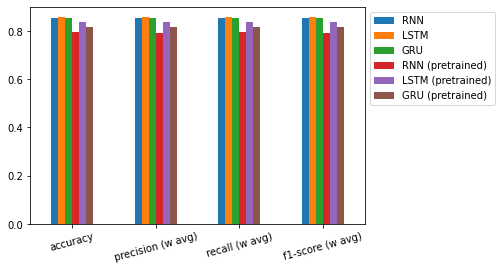

In [58]:
ax = report.plot.bar(rot=15)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1));